## 加载模型


In [1]:
import model

In [2]:
import cv2

import numpy as np
def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    w,h = img.size
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.size[::-1]
        
    else:
        imgW,imgH = img.size

    for line in result:
        cx =line['cx']
        cy = line['cy']
        degree =line['degree']
        w  = line['w']
        h = line['h']

        x1,y1,x2,y2,x3,y3,x4,y4 = model.xy_rotate_box(cx, cy, w, h, degree/180*np.pi)
        
        x1,y1,x2,y2,x3,y3,x4,y4 = model.box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp)

In [3]:
import time
from PIL import Image

p = './test/card.png'
img = Image.open(p).convert("RGB")
timeTake = time.time()
_,result,angle= model.model(img,
                                    detectAngle=True,##是否进行文字方向检测
                                    config=dict(MAX_HORIZONTAL_GAP=80,##字符之间的最大间隔，用于文本行的合并
                                    MIN_V_OVERLAPS=0.6,
                                    MIN_SIZE_SIM=0.6,
                                    TEXT_PROPOSALS_MIN_SCORE=0.2,
                                    TEXT_PROPOSALS_NMS_THRESH=0.3,
                                    TEXT_LINE_NMS_THRESH = 0.99,##文本行之间测iou值
                                    MIN_RATIO=1.0,
                                    LINE_MIN_SCORE=0.2,
                                    TEXT_PROPOSALS_WIDTH=0,
                                    MIN_NUM_PROPOSALS=0,                                               
                ),
                                    leftAdjust=True,##对检测的文本行进行向左延伸
                                    rightAdjust=True,##对检测的文本行进行向右延伸
                                    alph=0.1,##对检测的文本行进行向右、左延伸的倍数
                                    ifadjustDegree=True
                                   )
        
timeTake = time.time()-timeTake


It take:3.4039392471313477s
姓名小静
性别女民族汉
出生1987年9月17日
往址北京市海淀区西北旺东路
100号中关村科技园
公民身份号码370782198709170246


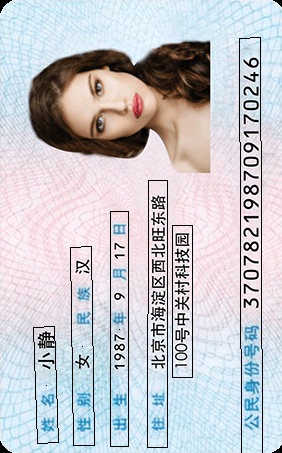

In [4]:
print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'])
plot_boxes(img,angle, result,color=(0,0,0))